In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
ada = pd.read_csv('/content/ada_k.csv')
artist_id = pd.read_csv('/content/lastfm_artist_list.csv')
user_scrobbles = pd.read_csv('/content/lastfm_user_scrobbles.csv')
combo = pd.read_csv('/content/lastfm.csv')

ada.shape, artist_id.shape, user_scrobbles.shape, combo.shape

((18700, 4), (17493, 2), (92792, 3), (289955, 4))

* Personalised recommendation -- Reviews and ...
* Non-personalised recommendation -- Common pairs.
* Text based -- Attributes/Features - Jaccard Similarity.
* Content Based -- Plot/Description/Summary - Cosine Similarity.
* Profile Recommendation --
* Collaborative filtering -- user based(similar users). -- item based (similar item feeling)
* KNNs
* Dealing with Sparsity - matrix factorisation -- singular value decomposition.
* Validation

### Overall Look

In [5]:
artist_id.head()

,artist_id,artist_name
0,1,__Max__
1,2,_Algol_
2,3,-123 Min.
3,4,-Oz-
4,5,-T De Sangre


In [6]:
user_scrobbles.head()

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690
2,1,494,11351
3,1,6673,10300
4,1,8402,8983


In [8]:
# merge to get the artist names on our scrobbles dataset
merged = pd.merge(left=user_scrobbles, right=artist_id, how='left', left_on='artist_id', right_on='artist_id')
merged.head()

,user_id,artist_id,scrobbles,artist_name
0,1,4562,13883,Duran Duran
1,1,10191,11690,Morcheeba
2,1,494,11351,Air
3,1,6673,10300,Hooverphonic
4,1,8402,8983,Kylie Minogue


number of unique artists: 17493
number of unique users: 1892


Text(0.5, 1.0, 'top 10 users who scrobble the most')

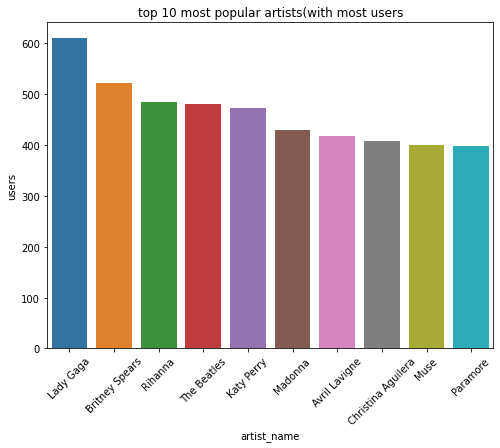

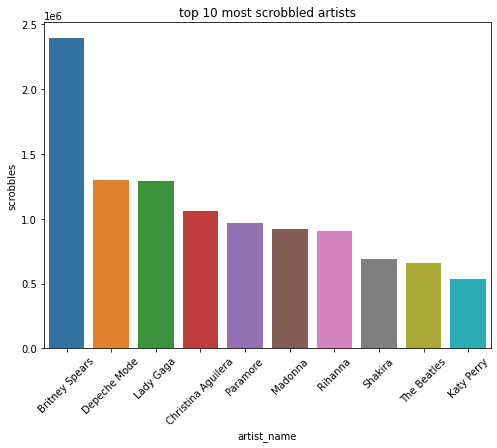

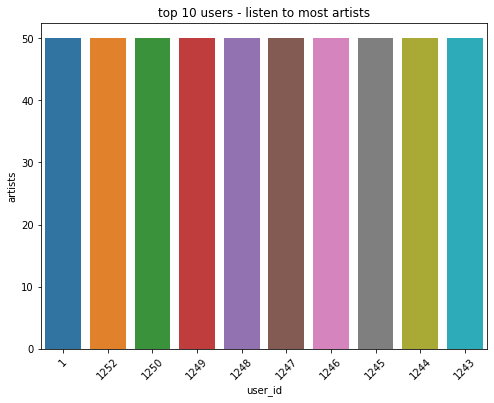

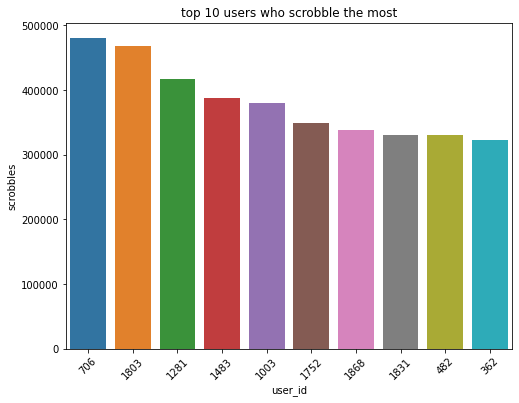

In [43]:
# how many users do we have, how many artists do we have?
print('number of unique artists:', merged['artist_id'].nunique())
print('number of unique users:', merged['user_id'].nunique())

# who's the most popular artist (many listeners)
pop = merged[['artist_name', 'user_id']].groupby('artist_name').agg({'user_id':'count'})
p = pop.sort_values('user_id', ascending = False).head(10)
plt.figure(figsize = (8,6))
sns.barplot(x = p.index, y = p.user_id, order=p.index)
plt.xticks(rotation = 45)
plt.title('top 10 most popular artists(with most users')
plt.ylabel('users')

# who's the most scrobbled artist
art = merged[['artist_name', 'scrobbles']].groupby('artist_name').agg({'scrobbles':'sum'})
a = art.sort_values('scrobbles', ascending = False).head(10)
plt.figure(figsize = (8,6))
sns.barplot(x = a.index, y = a.scrobbles, order=a.index)
plt.xticks(rotation = 45)
plt.title('top 10 most scrobbled artists')

# user who listens to the most artists
user = merged[['artist_id', 'user_id']].groupby('user_id').agg({'artist_id':'count'})
u = user.sort_values('artist_id', ascending = False).head(10)
plt.figure(figsize = (8,6))
sns.barplot(x = u.index, y = u.artist_id, order=u.index)
plt.xticks(rotation = 45)
plt.title('top 10 users - listen to most artists')
plt.ylabel('artists')

# who're the users who scrobble the most
uu = merged[['user_id', 'scrobbles']].groupby('user_id').agg({'scrobbles':'sum'})
usr = uu.sort_values('scrobbles', ascending = False).head(10)
plt.figure(figsize = (8,6))
sns.barplot(x = usr.index, y = usr.scrobbles, order=usr.index)
plt.xticks(rotation = 45)
plt.title('top 10 users who scrobble the most')

### Non-personalised recommendation 

In [95]:
# frequently listened to together (pairs - ) (most scrobbled my top srobblers ) - but now pairs
'''working with the top 10 datasets'''

# most scrobbled popular artists

'''artist similarity between users.'''
# group by user to get top 10 most scrobbled artists per user
users_artists = merged[['user_id', 'artist_name', 'scrobbles']]
pd.DataFrame(users_artists)

a = users_artists.groupby(['user_id', 'artist_name', 'scrobbles']).size().reset_index(
    name = 'count').sort_values(['user_id', 'scrobbles'], ascending = False).groupby(
        'user_id').head(25)
print(a.tail(20))

# group by user and store the top10 artists in a list for each user
b = a.groupby('user_id')['artist_name'].apply(list)
print(b.head(10))

# jaccard similarity baby (maybe just use sets for now cause )
# this function returns the similiraty of 2 users (artists wise)
# then makes a recommendattion
# comparing the similarity of all of them will require lots of research, 
# so for now, we just do pairwise comparison
top25 = pd.DataFrame(b)
def user1_user2(user1, user2): 
    list1, list2 = top25['artist_name'].loc[user1], top25['artist_name'].loc[user2]
    # intersection of the sets / 
    res = len(set(list1) & set(list2)) / float(len(set(list1) | set(list2))) * 100
    print(f"the percentage similarity in {user1}'s and {user2}'s top 25 artists is:", res)
    not_in1 = [item for item in list2 if item not in list1]
    not_in2 = [item for item in list1 if item not in list2]

    # recommendation part: (if similarity is at least 50%):
    if res >= 50:
        return f'{user2} should consider listening to {not_in2}, {user1} should consider listening to {not_in1} artists.'

# applying function on entire df (might make my laptop hang, so lets do 50 users first)
for i in range(1, 50):
    for j in range(1, 50):
        try:
            user1_user2(i,j)
        except Exception:
            print('user errors')

    user_id           artist_name  scrobbles  count
8         1             Daft Punk       6152      1
48        1  Thievery Corporation       5955      1
20        1             Goldfrapp       4616      1
38        1             New Order       4337      1
34        1           Matt Bianco       4147      1
46        1             Talk Talk       3923      1
41        1         Prefab Sprout       3782      1
15        1                Enigma       3735      1
42        1              Röyksopp       3644      1
6         1              Coldplay       3579      1
16        1             Faithless       3312      1
32        1               Madonna       3301      1
24        1              Icehouse       2927      1
43        1                  Sade       2720      1
36        1                  Moby       2686      1
11        1                  Dido       2654      1
10        1          Depeche Mode       2619      1
3         1          Cafe Del Mar       2584      1
2         1 

### Text based -- Attributes/Features - Jaccard Similarity.